In [69]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img
from torch.utils.data import DataLoader, Subset
import random

The image resolution is: 109x91


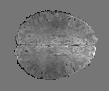

In [39]:
###--Load image with PIL and display--###
image_path = "./ground_truth.jpg"
image = Image.open(image_path)
W, H = image.size

image = image.resize((W, H))

# Print the dimensions
print(f"The image resolution is: {W}x{H}")
image.show()

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
###- DS LOCATION CONFIRMATION -###

jubin_ds = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(jubin_ds):
    print(f"YES! File found at: {jubin_ds}")
else:
    print(f"Error: File not found at: {jubin_ds}")
    
# loads ds
fmri = nib.load(jubin_ds)
fmri.shape

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


(91, 109, 91, 1200)

In [42]:
###- DS METADATA -###

print("=" * 80)

# ds shape
print(f"Shape: {fmri.get_fdata().shape}")

# characteristics of ds
print(f"Header information:\n{fmri.header}") 

# gets and displays num of slices in ds (typically 1200)
num_slices = fmri.shape[-1]
print(f"Number of slices: {num_slices}")

print("=" * 80)

Shape: (91, 109, 91, 1200)
Header information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [   4   91  109   91 1200    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    2.    0.72  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'FSL5.0')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)
0 255 (91, 109)


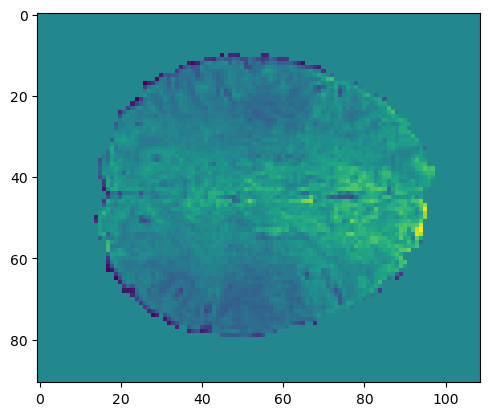

In [146]:
# gets volume
single_volume = index_img(fmri, 50)
arr = single_volume.get_fdata()

# sets timepoint
timepoint = 50

# takes 50th slice of volume, 50th timepoint
slice = arr[:,:, timepoint]

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalizes 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)
plt.imshow(norm_slice)
np.save('ground_truth.npy', norm_slice)
min_val = norm_slice.min()
max_val = norm_slice.max()

# Stretch the values to fill the 0-255 range for the image
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)

# 2. Convert the scaled data to unsigned 8-bit integers (the standard for images)
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# 3. Create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

(array([3.000e+01, 4.600e+01, 8.800e+01, 8.830e+02, 7.336e+03, 1.141e+03,
        3.250e+02, 5.900e+01, 6.000e+00, 5.000e+00]),
 array([-4.46320146, -3.50398588, -2.5447703 , -1.58555472, -0.62633914,
         0.33287644,  1.29209203,  2.25130761,  3.21052319,  4.16973877,
         5.12895435]),
 <BarContainer object of 10 artists>)

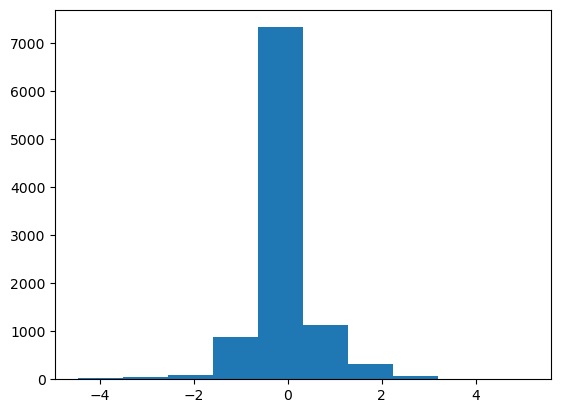

In [147]:
plt.hist(norm_slice.flatten())

In [148]:
###- BUILD DATAFRAME (NON-ZERO PIXELS ONLY) -###

# Transpose the normalized slice from (91, 109) to (109, 91) so height=109, width=91
bw_array = norm_slice.T
height, width = bw_array.shape
print(f"Shape of transposed slice: {bw_array.shape}")

# Create a boolean mask to identify the non-zero pixels (the brain region)
brain_mask = bw_array != 0

# Use np.where to get the coordinates (indices) of the brain pixels
# y_coords will be row indices (0-108), x_coords will be column indices (0-90)
y_coords, x_coords = np.where(brain_mask)

# Extract the intensity values for only the brain pixels using the mask
intensity_vals = bw_array[brain_mask]

num_brain_pixels = len(intensity_vals)
print(f"Found {num_brain_pixels} non-zero brain pixels out of {height * width} total pixels.")

# Normalize the coordinates of the brain pixels to the [0, 1] range
x_pos_norm = x_coords / (width - 1)
y_pos_norm = y_coords / (height - 1)

# To normalize intensity, find the min and max of the BRAIN region only
min_int = intensity_vals.min()
max_int = intensity_vals.max()
print(f"Intensity range of brain pixels: [{min_int:.4f}, {max_int:.4f}]")

# Normalize the brain intensities to the [0, 1] range
intensity_norm = (intensity_vals - min_int) / (max_int - min_int)

# Create the DataFrame using only the segmented brain data
df = pd.DataFrame({
    "x_pos": x_pos_norm,
    "y_pos": y_pos_norm,
    "intensity": intensity_norm
})

print("\nDataFrame created with non-zero pixels only.")
df.head()


Shape of transposed slice: (109, 91)
Found 4502 non-zero brain pixels out of 9919 total pixels.
Intensity range of brain pixels: [-4.4632, 5.1290]

DataFrame created with non-zero pixels only.


,x_pos,y_pos,intensity
0,0.555556,0.129630,0.068146
1,0.566667,0.129630,0.126463
2,0.400000,0.138889,0.261006
3,0.411111,0.138889,0.301404
4,0.422222,0.138889,0.339302


In [149]:
df.describe()

,x_pos,y_pos,intensity
count,4502.000000,4502.000000,4502.000000
mean,0.495365,0.500693,0.465297
std,0.193222,0.191691,0.104263
min,0.111111,0.129630,0.000000
25%,0.333333,0.342593,0.406371
50%,0.500000,0.500000,0.462861
75%,0.655556,0.657407,0.526206
max,0.877778,0.898148,1.000000


In [150]:
class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   
        # self.sig = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        # x = self.sig(x)

        return x

In [151]:
#Pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1)  

In [152]:
#Dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        if (fourier or gaussian) == False:
            #No positional encoding, just x and y
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos']
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [153]:
# creates a seed used to randomize training pixel grid
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # if you are using multi-GPU, these lines ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"SEED SET TO: {seed}")

In [164]:
#Function to train with different encoding types, set model_type to use different encodings
#STAF is a new INR that uses trainable parameter sinusoidal activation functions, just wanted to experiment with it: https://arxiv.org/abs/2502.00869
from tqdm import tqdm
import pickle
def train( num_freq, model_type, model_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1, visualize_split_flag=True):
    epoch_losses = []
    min_loss = 100
    
    if model_type == 'fourier':
        data = ImageINRDatasetFourier(df, fourier = True, num_freq = 1)
        model = fMRI_INRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDatasetFourier(df)
        model = fMRI_INRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        model = fMRI_INRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDatasetFourier(df)
        model = INR(2, 256, 4, 1).to(device)
    else:
        print('invalid model_type')
        return

      #--- DEV SET SPLIT ---#

    # gets ds size (expected 9919)
    ds_size = len(data)
    # indexes length of ds
    indices = list(range(ds_size))

    # randomizes indices
    np.random.shuffle(indices)
    
    # calculates size of training set (80% of full set)
    train_split = int(np.floor(0.8 * ds_size))
    
    # calculates size of validation set (10% of full set)
    val_split = int(np.floor(0.9 * ds_size))

    # 0 - train_split .. (80%)
    train_indices = indices[:train_split]
    # train_split - val_split .. (10%)
    val_indices = indices[train_split:val_split]
    # val_split - END .. (10%)
    test_indices = indices[val_split:]

    def visualize_split(full_df, train_indices):
        # pixel grid of the training dataset
        train_df = full_df.iloc[train_indices]

        # init figure
        plt.figure(figsize=(12, 6))
        
        # plots ALL pixels 
        plt.subplot(1, 2, 1)
        plt.scatter(full_df['x_pos'], full_df['y_pos'], s=1, alpha=0.5)
        plt.title(f'All Brain Pixels ({len(full_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')
    
        # plots ONLY TRAINING pixels
        plt.subplot(1, 2, 2)
        plt.scatter(train_df['x_pos'], train_df['y_pos'], s=1, alpha=0.5, color='orange')
        plt.title(f'Training Set Pixels ({len(train_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')

        # displays figure
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    # shows comparison when set to True
    if visualize_split_flag:
        visualize_split(data.dataframe, train_indices)

    # creates subsets
    train_dataset = Subset(data, train_indices)
    val_dataset = Subset(data, val_indices)
    test_dataset = Subset(data, test_indices) # TEST - *not used in training

    print(f"DS SPLIT: {len(train_dataset)} TRAIN, {len(val_dataset)} VAL, {len(test_dataset)} TEST")

    
    #--- TRAINING ---#

    train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True,)
    valid_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False,)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    patience = 50  
    epochs_no_improve = 0
    best_val_loss = float('inf')
    print(f'PATIENCE: {patience}')
    
    train_losses = []
    valid_losses = []

    num_epochs = 600

    for epoch in tqdm(range(num_epochs)):
        model.train()  
        
        running_train_loss = 0.0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

                 
        #--- VALIDATION ---#
        
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(valid_dataloader.dataset)
        valid_losses.append(epoch_val_loss)

        if (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }

        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

        torch.save(checkpoint, model_file)

    print(f"\nSaving loss histories to '{loss_file}'...")
    loss_data = {
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }
    with open(loss_file, 'wb') as f:
        pickle.dump(loss_data, f)
    print("Save complete.")
        
    return train_losses, valid_losses



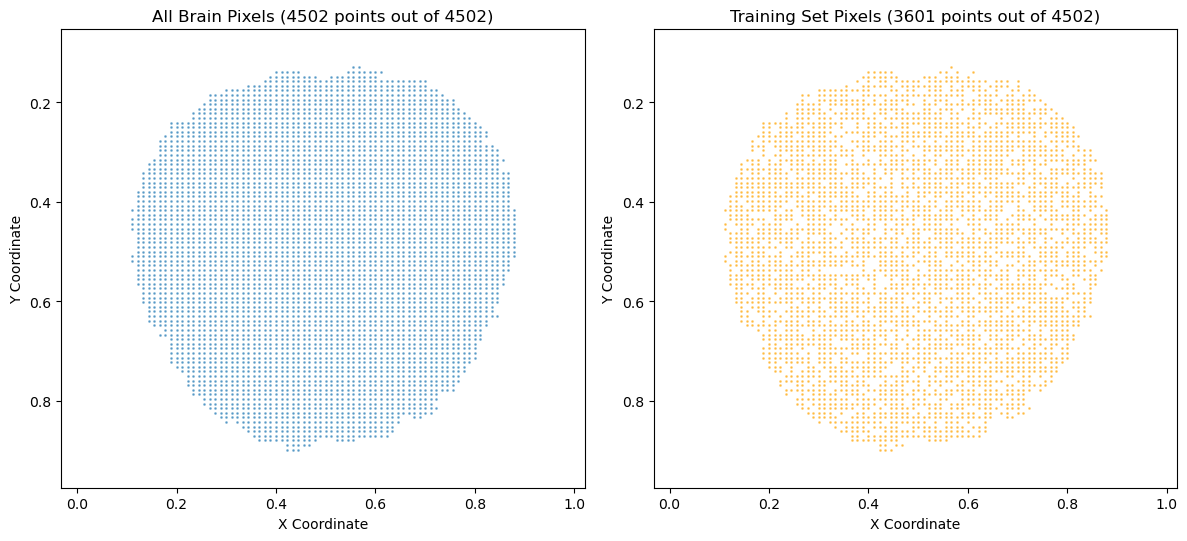

DS SPLIT: 3601 TRAIN, 450 VAL, 451 TEST
PATIENCE: 50


  5%|▌         | 30/600 [00:05<01:44,  5.44it/s]

Epoch 30/600, Train Loss: 0.005446, Val Loss: 0.006093


 10%|█         | 60/600 [00:10<01:31,  5.88it/s]

Epoch 60/600, Train Loss: 0.004982, Val Loss: 0.004868


 15%|█▌        | 90/600 [00:16<01:33,  5.47it/s]

Epoch 90/600, Train Loss: 0.004714, Val Loss: 0.004725


 20%|██        | 120/600 [00:21<01:27,  5.48it/s]

Epoch 120/600, Train Loss: 0.004514, Val Loss: 0.004669


 25%|██▌       | 150/600 [00:27<01:30,  5.00it/s]

Epoch 150/600, Train Loss: 0.004312, Val Loss: 0.004630


 30%|███       | 180/600 [00:32<01:16,  5.51it/s]

Epoch 180/600, Train Loss: 0.004033, Val Loss: 0.004486


 35%|███▌      | 210/600 [00:38<01:11,  5.45it/s]

Epoch 210/600, Train Loss: 0.003902, Val Loss: 0.004924


 40%|████      | 240/600 [00:44<01:01,  5.82it/s]

Epoch 240/600, Train Loss: 0.003230, Val Loss: 0.003822


 45%|████▌     | 270/600 [00:49<01:14,  4.46it/s]

Epoch 270/600, Train Loss: 0.003387, Val Loss: 0.003740


 50%|█████     | 300/600 [00:54<00:51,  5.81it/s]

Epoch 300/600, Train Loss: 0.002693, Val Loss: 0.003367


 55%|█████▌    | 330/600 [01:00<00:47,  5.68it/s]

Epoch 330/600, Train Loss: 0.002997, Val Loss: 0.003788


 60%|██████    | 360/600 [01:05<00:41,  5.72it/s]

Epoch 360/600, Train Loss: 0.002589, Val Loss: 0.003334


 65%|██████▌   | 390/600 [01:11<00:38,  5.45it/s]

Epoch 390/600, Train Loss: 0.002328, Val Loss: 0.003174


 70%|███████   | 420/600 [01:16<00:32,  5.57it/s]

Epoch 420/600, Train Loss: 0.002303, Val Loss: 0.003156


 75%|███████▍  | 449/600 [01:22<00:27,  5.49it/s]

Epoch 450/600, Train Loss: 0.002359, Val Loss: 0.003124


 80%|████████  | 480/600 [01:28<00:22,  5.34it/s]

Epoch 480/600, Train Loss: 0.002034, Val Loss: 0.003029


 85%|████████▌ | 510/600 [01:33<00:15,  5.94it/s]

Epoch 510/600, Train Loss: 0.001912, Val Loss: 0.003014


 90%|█████████ | 540/600 [01:39<00:10,  5.92it/s]

Epoch 540/600, Train Loss: 0.001848, Val Loss: 0.003095


 95%|█████████▌| 570/600 [01:44<00:04,  6.05it/s]

Epoch 570/600, Train Loss: 0.001773, Val Loss: 0.003082


100%|██████████| 600/600 [01:50<00:00,  5.44it/s]

Epoch 600/600, Train Loss: 0.002495, Val Loss: 0.004397

Saving loss histories to 'NZ_loss'...
Save complete.


In [165]:
train_losses, valid_losses = train(
    num_freq = 256, 
    model_type = 'gaussian', 
    model_file ='NZ_run.pth', 
    loss_file = 'NZ_loss', 
    freq_file = 'NZ.pkl', 
    gauss_scale = 10
)

Reconstructing for dimensions: 109x91
Shape of encoded coordinate grid: torch.Size([9919, 1024])

--- Reconstructed Image (Masked) ---


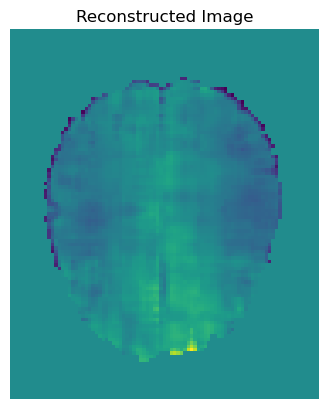


--- Ground Truth ---


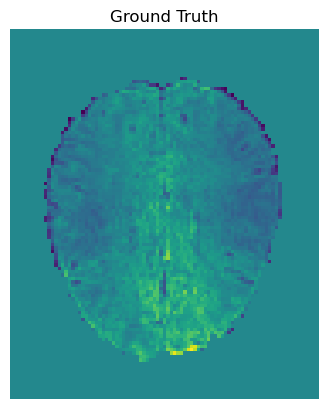


--- Difference Image ---


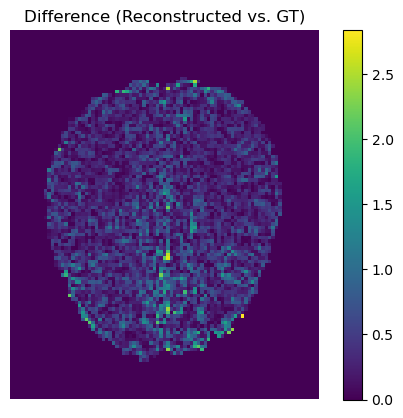

In [166]:
# Re-define the model architecture for inference
num_freq = 256
model = fMRI_INRModel(input_size = 4*num_freq) 

# Define path to the saved model checkpoint 
path = './NZ_run.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Get the original image dimensions (after transpose)
H, W = norm_slice.T.shape
print(f"Reconstructing for dimensions: {H}x{W}")

# Create a coordinate grid for the entire image space
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)

# This ensures the coordinate grid is created in the correct row-major order
X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)

# Load the frequencies used during training for positional encoding
with open('./NZ.pkl', 'rb') as file:
    freq = pickle.load(file)

# Apply the same fourier encoding to the full coordinate grid
X_encoded = fourier_encode(X, freq = freq)
print(f"Shape of encoded coordinate grid: {X_encoded.shape}")

# Perform inference
with torch.no_grad():
    Y = model(X_encoded) 

# Reshape the output back into an image and un-normalize it.
min_int = norm_slice[norm_slice != 0].min()
max_int = norm_slice.max()
image_normalized_output = Y.reshape(H, W, 1)
image_unnormalized = (image_normalized_output * (max_int - min_int)) + min_int

### FIX: Apply Brain Mask to Remove Background Artifacts ###
# 1. Create a boolean mask from the original transposed slice (True for brain, False for background)
brain_mask_np = (norm_slice.T != 0) 
# 2. Convert the numpy mask to a PyTorch tensor, add a channel dimension, and convert to float for multiplication
brain_mask_tensor = torch.from_numpy(brain_mask_np).unsqueeze(-1).float()
# 3. Multiply the reconstructed image by the mask. This sets all background pixels to zero.
reconstructed_masked = image_unnormalized * brain_mask_tensor
### END FIX ###

# Create the ground truth image from the original DataFrame for comparison
gt_array = np.zeros((H, W))
y_indices = (df['y_pos'] * (H - 1)).round().astype(int).values
x_indices = (df['x_pos'] * (W - 1)).round().astype(int).values
gt_unnormalized_intensities = (df['intensity'].values * (max_int - min_int)) + min_int
gt_array[y_indices, x_indices] = gt_unnormalized_intensities
gt_tensor_unnormalized = torch.from_numpy(gt_array).unsqueeze(-1)

# Calculate the difference image using the masked reconstruction
diff_image = torch.abs(gt_tensor_unnormalized - reconstructed_masked).squeeze()

print('\n--- Reconstructed Image (Masked) ---')
plt.imshow(reconstructed_masked.squeeze())
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

print('\n--- Ground Truth ---')
plt.imshow(gt_tensor_unnormalized.squeeze())
plt.title('Ground Truth')
plt.axis('off')
plt.show()

print('\n--- Difference Image ---')
plt.imshow(diff_image)
plt.title('Difference (Reconstructed vs. GT)')
plt.colorbar()
plt.axis('off')
plt.show()


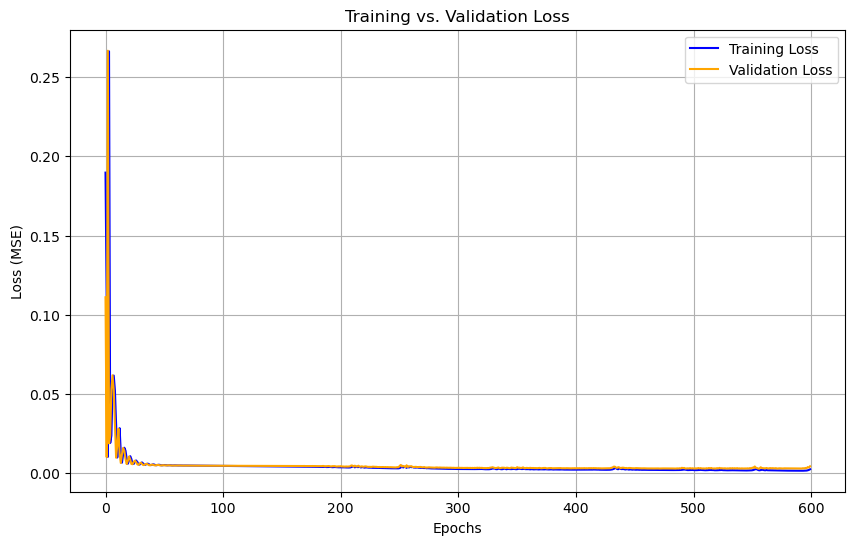

In [167]:
import matplotlib.pyplot as plt

# assembles figure
plt.figure(figsize=(10, 6))

# training loss plot
plt.plot(train_losses, label='Training Loss', color='blue')

# validation loss plot
plt.plot(valid_losses, label='Validation Loss', color='orange')

# adds titles
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.show()
